# Data source: "Mice proteins"
* [paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0129126)
* [Dataset](https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression)

In [2]:
library(ggplot2)
library(rrcov)
library(reshape)
library(caret)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
“package ‘rrcov’ was built under R version 3.6.2”Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.5-2)

Loading required package: lattice


# Load data

In [3]:
dat <- read.table('data/mice_proteins.txt',sep='\t',header=TRUE)
rownames(dat) <- dat$MouseID
dat$MouseID <- NULL

# Create some learning-type factors

In [4]:
learningTypeMap <- c('normal','normal','none','none','rescued','failed','none','none')
names(learningTypeMap) <- levels(dat$class)
learningMap <- c('learning','learning','nolearning','nolearning')
names(learningMap) <- c('normal','rescued','failed','none')
dat$LearningType <- factor(learningTypeMap[dat$class])
dat$Learning <- factor(learningMap[dat$LearningType])

# Define some functions for normalization

In [5]:
library(preprocessCore)

get.qdat <- function(dat){
    # converts to quantitative matrix data (without categorical metadata)
    ret <- as.matrix(dat[,1:77])
    colnames(ret) <- colnames(dat[1:77])
    ret
}
get.mdat <- function(dat){
    # converts to only categorical metadata
    dat[,78:ncol(dat)]
}

norm.dat <- function(dat.in,qnorm=FALSE,scale=FALSE){
    # performs normalization (quantile and/or scale)
    dat <- data.frame(dat.in)
    qdat <- get.qdat(dat)
    mdat <- get.mdat(dat)
    if(qnorm){
        qdat <- normalize.quantiles(qdat)
    }
    if(scale){
        qdat <- (qdat-apply(qdat,2,mean))-apply(qdat,2,sd)
    }
    ret <- cbind.data.frame(qdat,mdat)
    rownames(ret) <- rownames(dat)
    colnames(ret) <- colnames(dat)
    ret
}

Warning message:
“package ‘preprocessCore’ was built under R version 3.6.1”

In [6]:
dat <- norm.dat(dat,qnorm=TRUE,scale=FALSE)

# Melt the data matrix into a data frame

In [7]:
df <- melt(cbind(individual=rownames(dat),dat), id=c("individual","Genotype","Treatment","Behavior","class","LearningType","Learning"))

# Check that the normalization worked

Warning message:
“Removed 1396 rows containing non-finite values (stat_ydensity).”

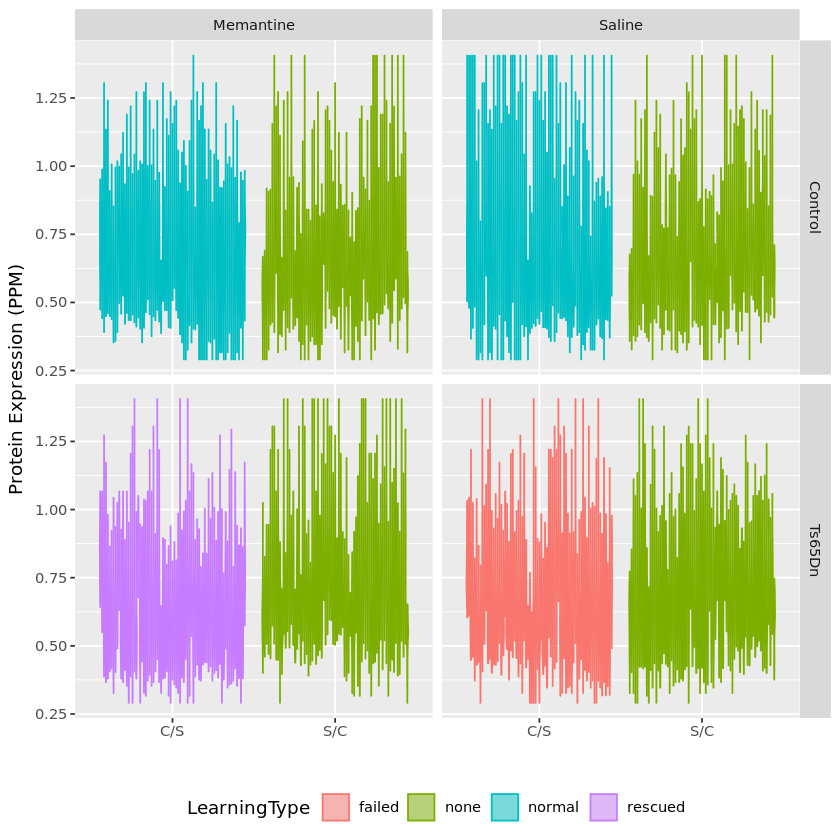

In [8]:
ggplot(
    df
) +
geom_violin(aes(Behavior,value,group=Behavior:variable,color=LearningType,fill=LearningType),alpha=.5) +
xlab("") + ylab("Protein Expression (PPM)") +
facet_grid(Genotype~Treatment) +
theme(legend.position="bottom")

# Define a function for PCA
Functions like this are useful when trying different datasets and types of preprocessing, hyperparameters, etc

In [9]:
doPCA <- function(dat,robust=TRUE,scale=FALSE,plot=FALSE){
    qdat <- get.qdat(dat)
    qdat[is.na(qdat)] <- 0
    mdat <- get.mdat(dat)
    
    if(robust){
        # perform robust pca, which includes outlier detection
        robust.pca <- PcaGrid(qdat,scale=scale)
        sddf <- data.frame(sd=robust.pca@sd,outlier='',stringsAsFactors=FALSE)
        sddf$outlier[robust.pca@sd > robust.pca@cutoff.sd] <- 'outlier'
        sddf$individual <- rownames(sddf)
        pca.pred <- predict(robust.pca,qdat)
        pc1 <- pca.pred[,1]
        pc2 <- pca.pred[,2]
        pvar1 <- 100*summary(robust.pca)@importance[2,1]
        pvar2 <- 100*summary(robust.pca)@importance[2,1]
        ret <- robust.pca
    }else{
        # perform a normal pca
        pca <- prcomp(qdat,center=scale,scale.=scale)
        sddf <- data.frame(individual=rownames(qdat),sd=1,outlier='',stringsAsFactors=FALSE)
        pca.pred <- predict(pca,qdat)
        pc1 <- pca.pred[,1]
        pc2 <- pca.pred[,2]
        pvar1 <- 100*summary(pca)$importance[2,1]
        pvar2 <- 100*summary(pca)$importance[2,1]
        pca$sddf <- sddf
        ret <- pca
    }
    
    if(plot){
        # optionally plot the resulting top 2 PCs
        pca.plot.dat <- merge(
            cbind.data.frame(
                individual=names(pc1),
                PC1=pc1,
                PC2=pc2,
                Genotype=dat$Genotype,
                Treatment=dat$Treatment,
                Behavior=dat$Behavior,
                LearningType=dat$LearningType,
                Learning=dat$Learning,
                class=dat$class
            ),
            sddf
        )
        
        print(
            ggplot(pca.plot.dat) +
            geom_point(aes(PC1,PC2,color=LearningType,shape=outlier,size=sd),alpha=.5) +
            xlab(sprintf('PC1 (%.2f%% var)',pvar1)) + ylab(sprintf('PC2 (%.2f%% var)',pvar2)) +
            theme(legend.position='bottom') +
            facet_grid(Genotype~Treatment)
        )
    }
    
    return(ret)
}

# Perform PCA

In [ ]:
robust.pca <- doPCA(dat,robust=TRUE,scale=TRUE,plot=TRUE)

# ...without scaling

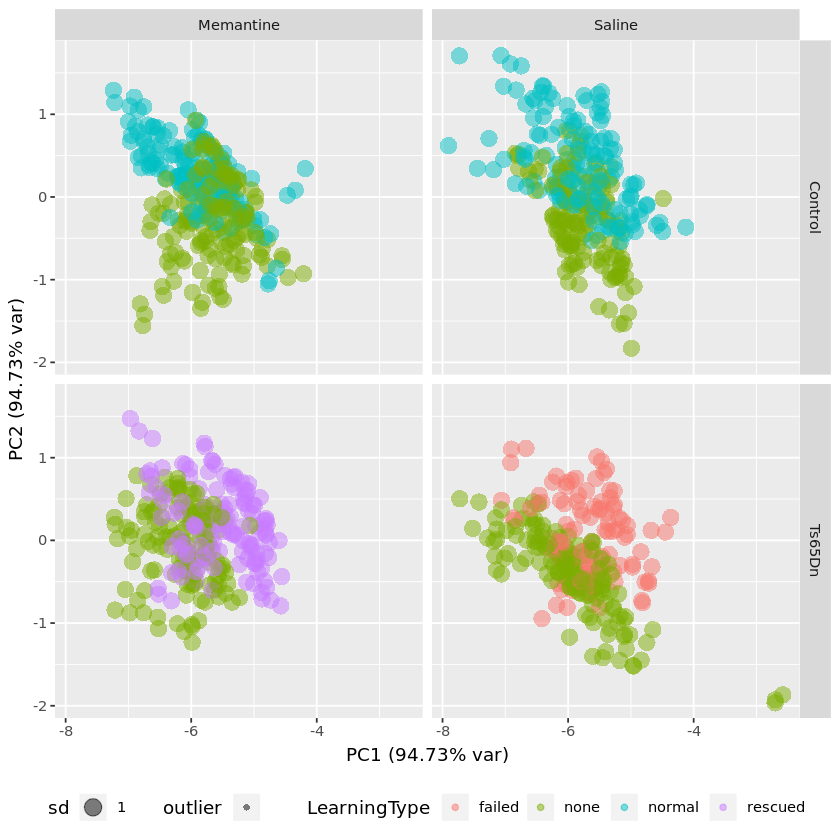

In [10]:
pca <- doPCA(dat,robust=FALSE,scale=FALSE,plot=TRUE)

# ...and with scaling
notice how much better separater results after scaling

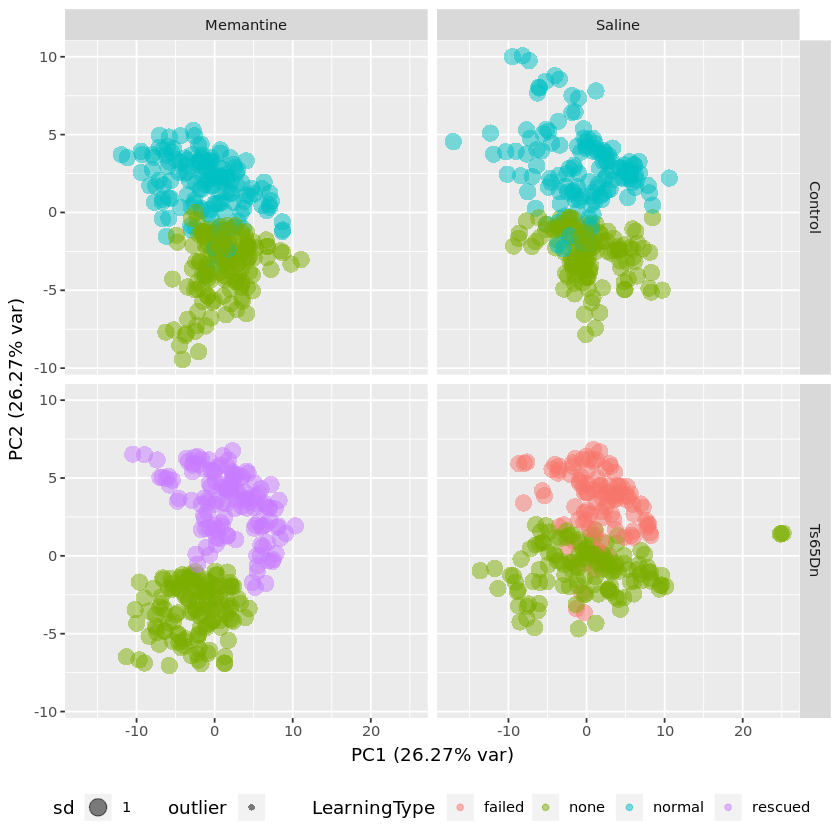

In [11]:
pca <- doPCA(dat,robust=FALSE,scale=TRUE,plot=TRUE)

# Classification with PLS-DA

In [12]:
dat.pls <- dat

X <- get.qdat(dat.pls)
X[is.na(X)] <- 0
Y <- dat.pls$LearningType

# Select a random training and testing set

In [13]:
set.seed(123)
train.idx <- createDataPartition(Y, p = .8, list = FALSE)

In [14]:
Xtrain <- X[train.idx,]
Xtest <- X[-train.idx,]
Ytrain <- Y[train.idx]
Ytest <- Y[-train.idx]

# Perform Sparse PLS-DS

In [15]:
splsFit <- caret:::splsda(Xtrain, Ytrain,
    K = 2, eta = .9,
    probMethod = "softmax")

Registered S3 methods overwritten by 'spls':
  method         from 
  predict.splsda caret
  print.splsda   caret


In [16]:
confusionMatrix(caret:::predict.splsda(splsFit, Xtest),Ytest)

Confusion Matrix and Statistics

          Reference
Prediction failed none normal rescued
   failed       0    0      0       0
   none         3  111      4       2
   normal      16    0     53      20
   rescued      2    0      0       5

Overall Statistics
                                          
               Accuracy : 0.7824          
                 95% CI : (0.7214, 0.8355)
    No Information Rate : 0.5139          
    P-Value [Acc > NIR] : 3.308e-16       
                                          
                  Kappa : 0.6384          
                                          
 Mcnemar's Test P-Value : 1.871e-08       

Statistics by Class:

                     Class: failed Class: none Class: normal Class: rescued
Sensitivity                0.00000      1.0000        0.9298        0.18519
Specificity                1.00000      0.9143        0.7736        0.98942
Pos Pred Value                 NaN      0.9250        0.5955        0.71429
Neg Pred Value         

# Check the top projected components (proteins)

In [17]:
splsFit$projection

,Comp 1,Comp 2
pERK_N,0.0127216119,0.003710059
SOD1_N,-0.0129633031,-0.005792717
AMPKA_N,0.0001891939,-0.019829353
pNUMB_N,0.0068658407,-0.015880202
CaNA_N,0.0122469272,0.002318361


In [18]:
spls.plot.dat <- data.frame(
    PC1=robust.pca@scores[rownames(dat.pls),1],
    PC2=robust.pca@scores[rownames(dat.pls),2],
    dat.pls[,rownames(splsFit$projection)],
    Genotype=dat.pls$Genotype,
    Treatment=dat.pls$Treatment,
    Behavior=dat.pls$Behavior,
    LearningType=dat.pls$LearningType
)

ERROR: Error in data.frame(PC1 = robust.pca@scores[rownames(dat.pls), 1], PC2 = robust.pca@scores[rownames(dat.pls), : object 'robust.pca' not found


Warning message:
“Removed 3 rows containing missing values (geom_point).”

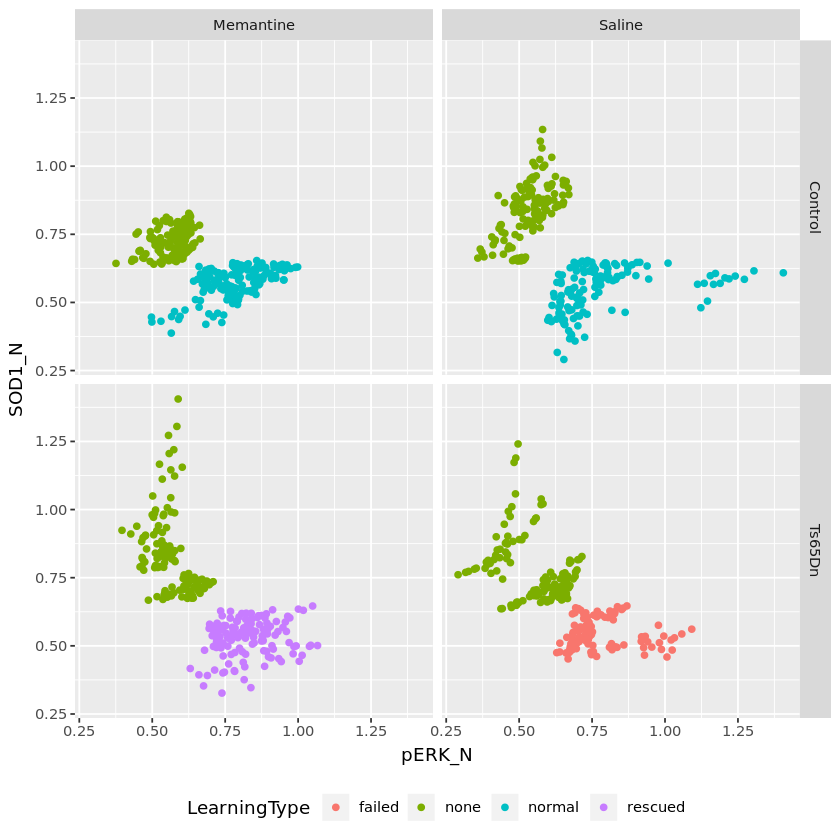

In [34]:
ggplot(spls.plot.dat) +
geom_point(aes_string(rownames(splsFit$projection)[1],rownames(splsFit$projection)[2],color='LearningType')) +
theme(legend.position="bottom") +
facet_grid(Genotype~Treatment)

Warning message:
“Removed 3 rows containing missing values (geom_point).”

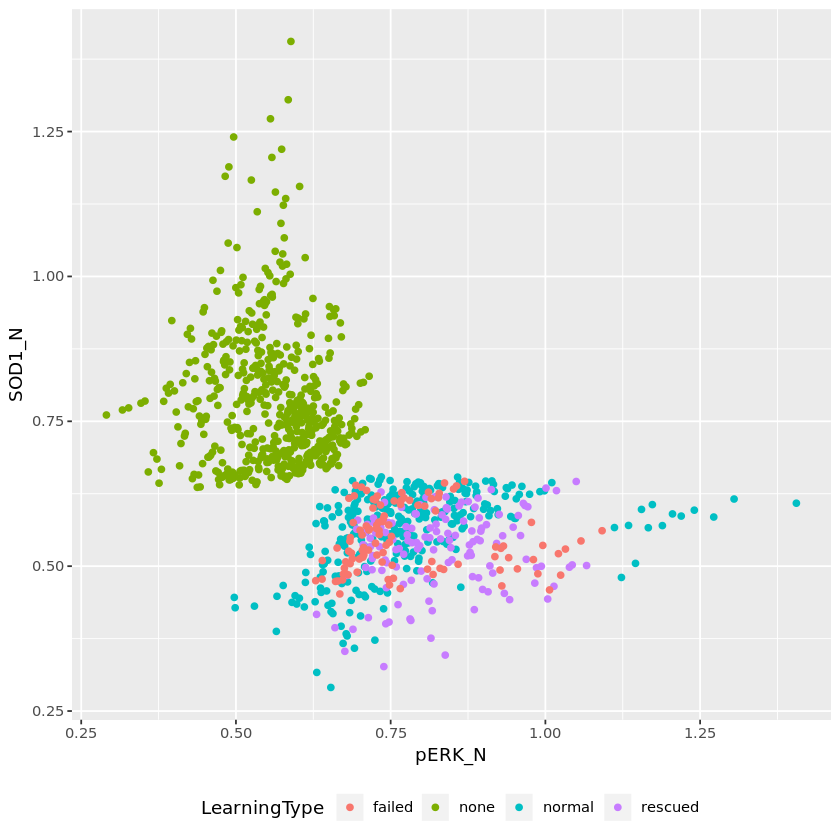

In [35]:
ggplot(spls.plot.dat) +
geom_point(aes_string(rownames(splsFit$projection)[1],rownames(splsFit$projection)[2],color='LearningType')) +
theme(legend.position="bottom")

In [ ]:
write.csv(dat,file='data/mice_proteins_cleaned.csv')